In [138]:
# Run first time only (doesn't matter much)
#%pip install pandas numpy matplotlib scipy statsmodels linearmodels arch stargazer

In [139]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import sys
sys.path.append("../src")


In [140]:
# Adjusing Parameters
tickers = ['VIC', 'VCB', 'VHM', 'CTG', 'BID', 'TCB', 'VPB', 'HPG']
start_date = '2025-01-01'
end_date = '2025-12-24'
interval_select = '1d'

In [141]:
from vnstock import Listing, Quote

# Define Listing for accessibility
listing = Listing(source="VCI") 
VN30 = listing.symbols_by_group("VN30")

parent = []
for stock in tickers:
    quote = Quote(symbol= stock, source="VCI")
    df = quote.history(start=start_date, end=end_date, interval=interval_select)
    df['ticker'] = stock
    df['time'] = pd.to_datetime(df['time'])
    df['m_volume'] = df['volume'] * df['close']
    df['ret'] = df['close'].pct_change()
    df['log_ret'] = np.log(df['close']).diff()

    parent.append(df)

panel = pd.concat(parent, ignore_index=False)
panel

,time,open,high,low,close,volume,ticker,m_volume,ret,log_ret
0,2024-12-12,20.65,20.68,20.45,20.45,2149810,VIC,4.396361e+07,NaN,NaN
1,2024-12-13,20.38,20.45,20.30,20.40,1953741,VIC,3.985632e+07,-0.002445,-0.002448
2,2024-12-16,20.40,20.45,20.30,20.35,1161340,VIC,2.363327e+07,-0.002451,-0.002454
3,2024-12-17,20.35,20.40,20.27,20.27,1332060,VIC,2.700086e+07,-0.003931,-0.003939
4,2024-12-18,20.27,20.42,20.27,20.30,852659,VIC,1.730898e+07,0.001480,0.001479
...,...,...,...,...,...,...,...,...,...,...
253,2025-12-18,26.40,26.55,26.25,26.40,18777900,HPG,4.957366e+08,0.000000,0.000000
254,2025-12-19,26.40,26.70,26.40,26.70,29580600,HPG,7.898020e+08,0.011364,0.011300
255,2025-12-22,26.70,27.10,26.60,26.90,54880900,HPG,1.476296e+09,0.007491,0.007463
256,2025-12-23,27.05,27.20,26.65,26.75,29588500,HPG,7.914924e+08,-0.005576,-0.005592


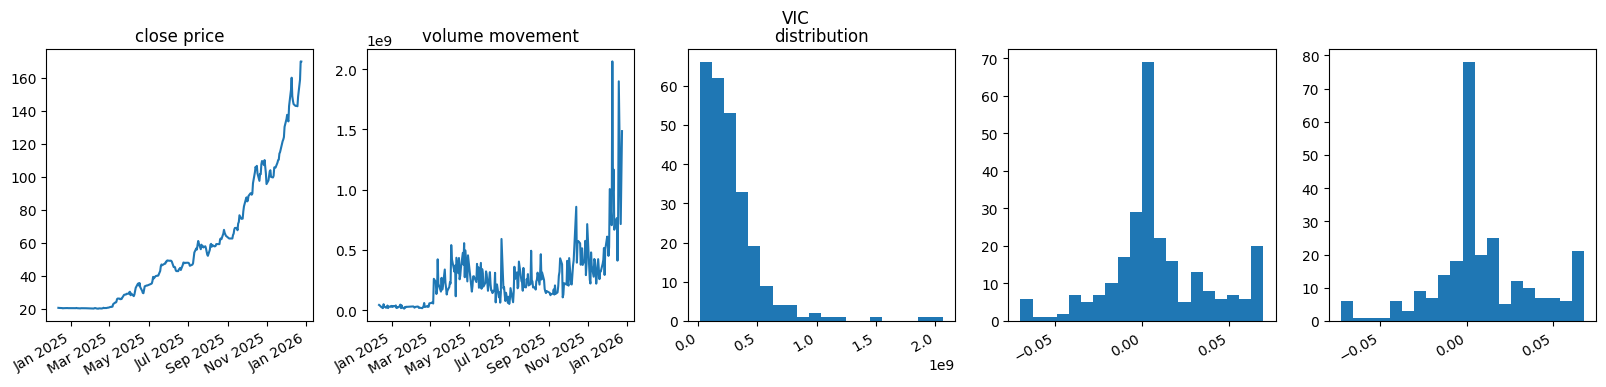

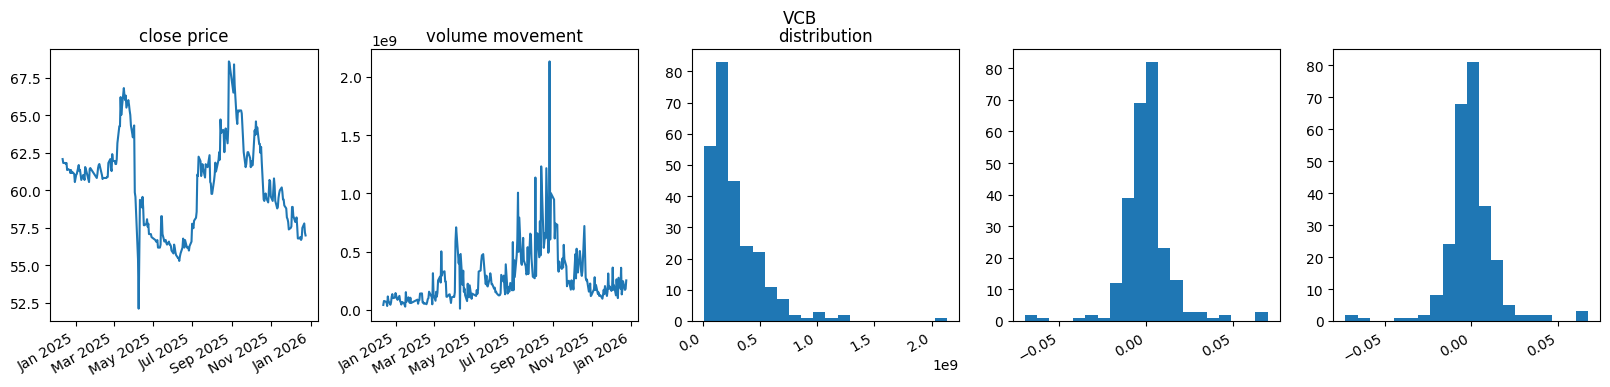

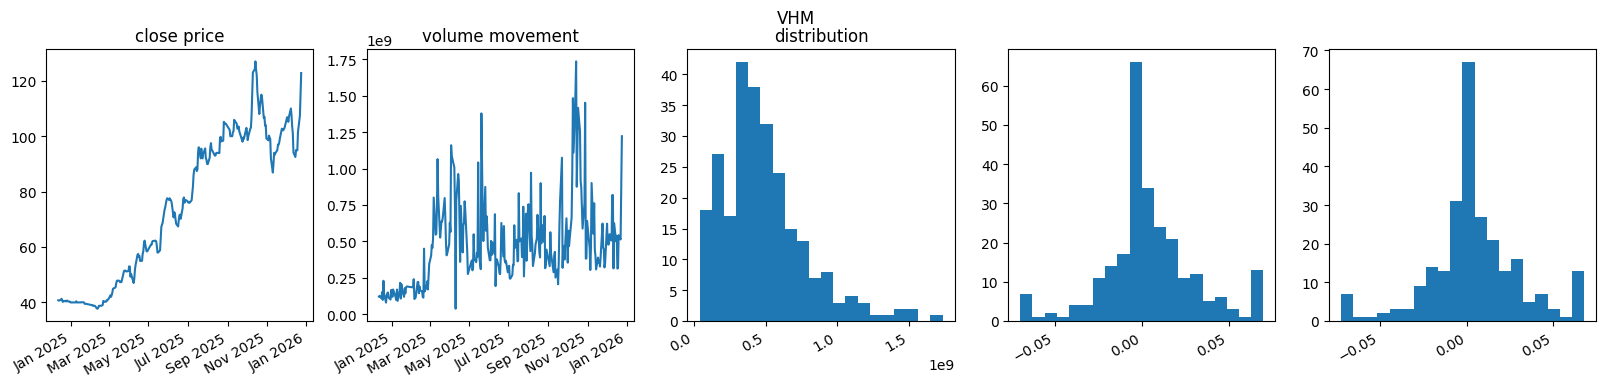

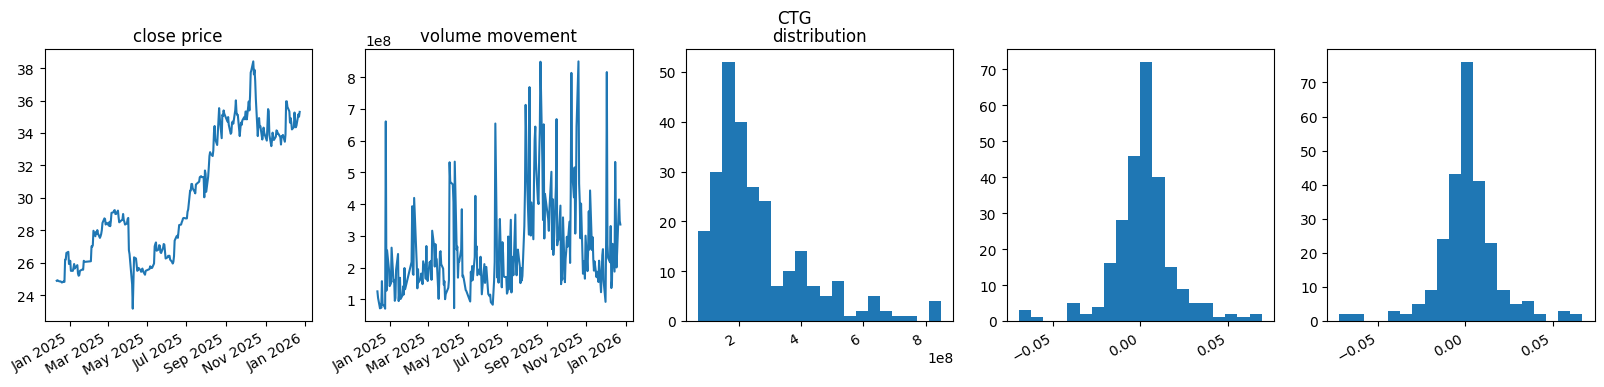

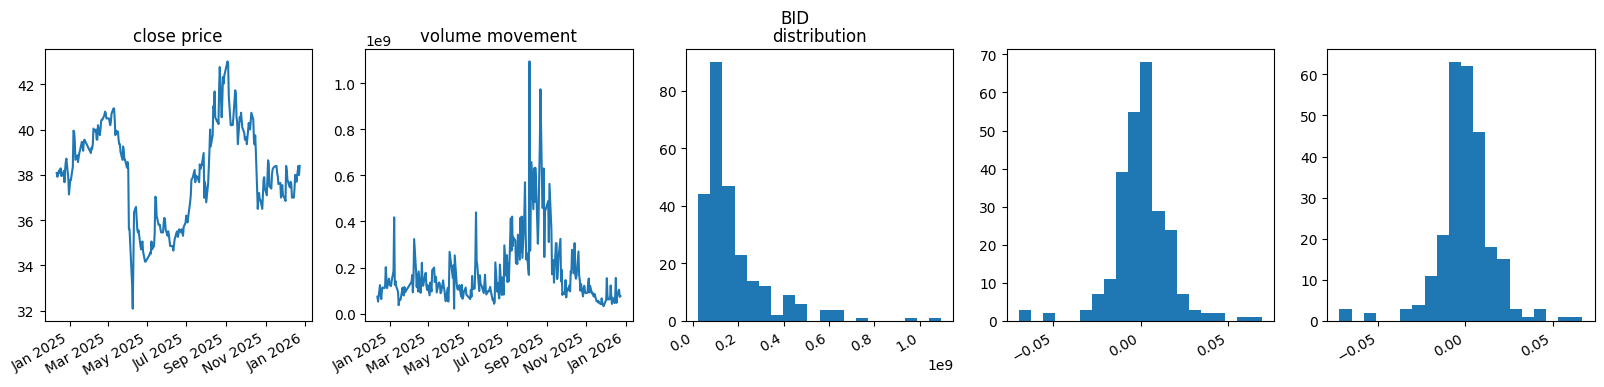

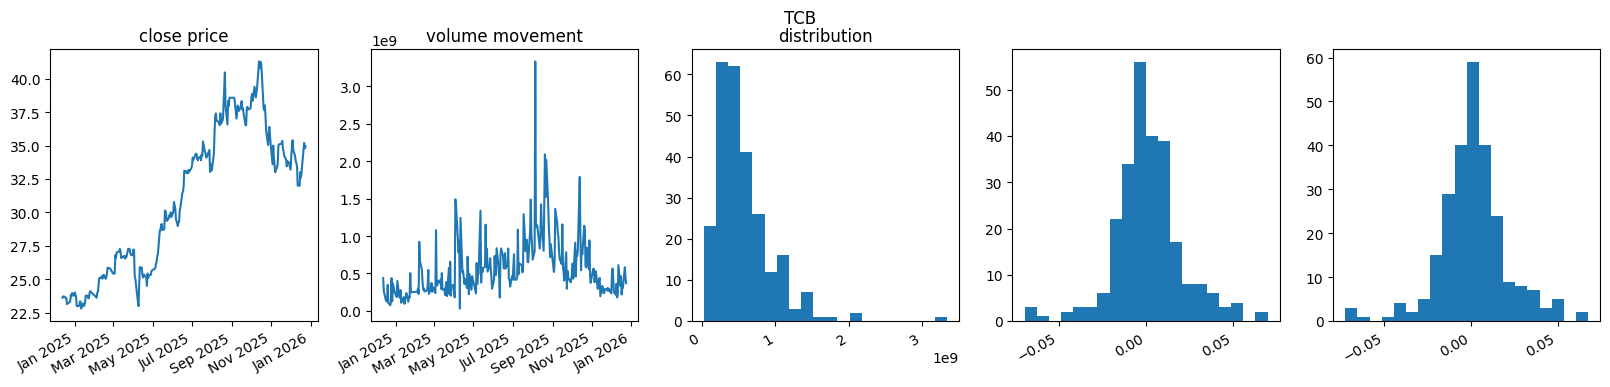

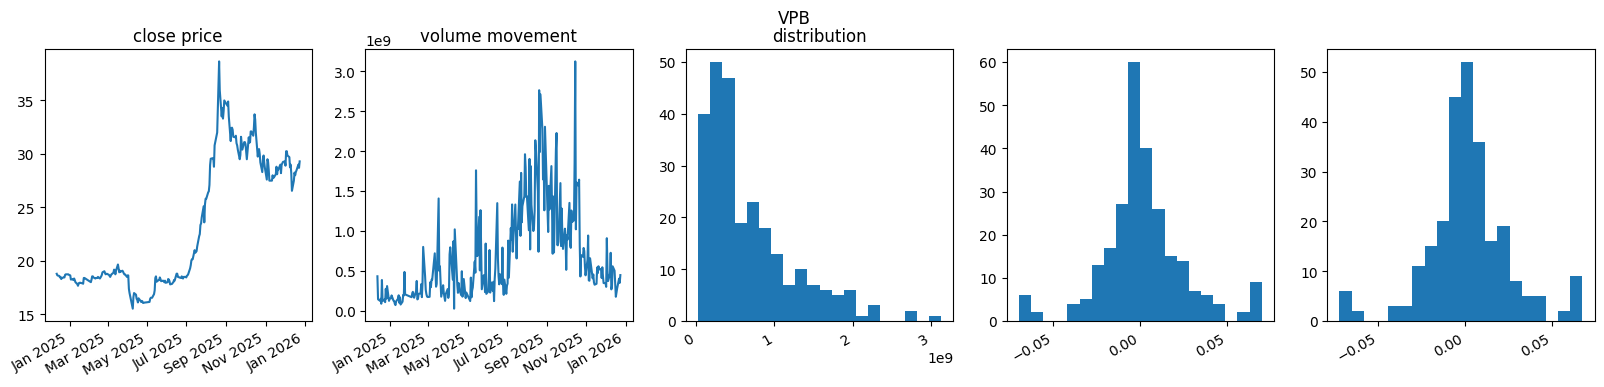

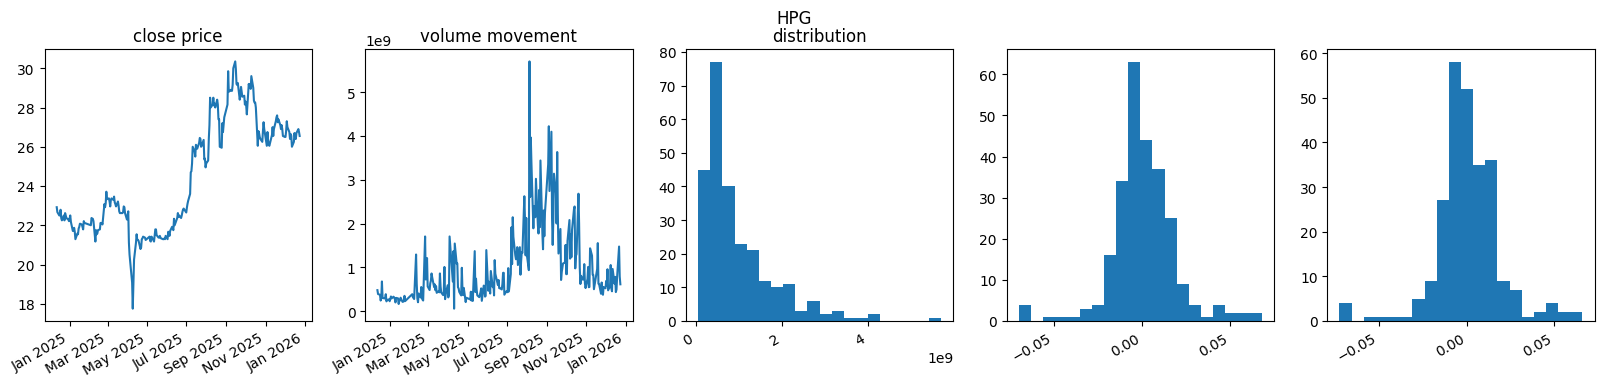

In [142]:
date_format = mdates.DateFormatter("%b %Y")

for stock in tickers:
    df = panel[panel['ticker'] == stock]
    fig, axs = plt.subplots(1, 5, figsize=(20,4))
    # Plots
    axs[0].plot(df['time'], df['close'])
    axs[1].plot(df['time'], df['m_volume'])
    axs[2].hist(df['m_volume'], 20)
    axs[3].hist(df['ret'], 20)
    axs[4].hist(df['log_ret'], 20)
    # Title
    axs[1].set_title("volume movement")
    axs[0].set_title("close price")
    axs[2].set_title("distribution")
    # Set X Axis to date format
    axs[0].xaxis.set_major_formatter(date_format)
    axs[1].xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    fig.suptitle(f"{stock}")
    plt.show()
